#### `Squared` loss function

So far, we have been using the squared loss function

$$J=\frac{1}{m}\sum_{i=1}^{m}\,(y_{\text{pred},i}-y_{\text{act},i})^2$$

where $m$ is the number of data samples used to find the model parameters, and $y_{\text{pred,i}}=a\cdot x_i+b$

We also know how to compute the `gradient` w.r.t. $a$ and $b$

$$\begin{align*}
\frac{\partial J}{\partial a}&=\frac{1}{m}\sum_{i=1}^{m}\,(a\cdot x_i+b-y_{\text{act},i})\cdot x_i\\
\frac{\partial J}{\partial b}&=\frac{1}{m}\sum_{i=1}^{m}\,(a\cdot x_i+b-y_{\text{act},i})\cdot 1
\end{align*}$$

which can be used to iteratively adjust $a$ and $b$ to minimize the loss function

#### Potential `issue`

What we haven't talked about a lot is why we choose to formulate our loss function this way. There are a few reasons for this choice

* by taking sum of squares of prediction error, we are saying that we don't distinguish whether our model is underpredicting or overpredicting
* squared loss is mathematically convenient (due to its quadratic nature), and it has a nice analytical solution as well

While these are true, sometimes we need to be more careful about other issues when making a choice. One of such issue in our case is that, as the error goes large, the penalty imposed by the loss function goes up quadratically, making our algorithm sensitive to large prediction errors

One scenario we can encounter such large errors is when there are severe `outliers` in our data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

In [ ]:
np.random.seed(42)

# Create noisy data along a line
x = np.linspace(0, 6, 15)
y = 2 * x + 3 + np.random.normal(0, 1, len(x))

# Two outliers
x = np.append(x, [1, 5]) # 1d array
y = np.append(y, [15, 0]) # 1d array

In [ ]:
# Squared loss function
def grad_squared_loss(x, y, a, b):
    y_pred = a * x + b
    da = np.mean((y_pred - y) * x)
    db = np.mean(y_pred - y)
    return da, db

In [ ]:
learning_rate = 0.01
iterations = 2000

# Initial guess
a = 0.0
b = 0.0

for i in range(iterations):
    da, db = grad_squared_loss(x, y, a, b)

    # Update a and b in negative gradient direction
    a -= learning_rate * da
    b -= learning_rate * db

print(f"Final parameters: a = {a:.4f}, b = {b:.4f}")

Final parameters: a = 0.9632, b = 5.9360


In [ ]:
# Analytical solution, just to check whether our numerical solution goes wrong
A = np.hstack([x.reshape(-1, 1), np.ones((len(x), 1))])
theta = np.linalg.inv(A.T@A)@A.T@y
theta

array([ 0.9565,  5.9632])

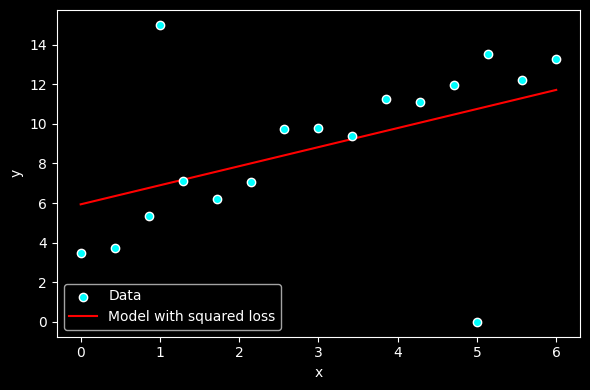

In [ ]:
def prediction(x, a, b):
    return a * x + b

fig, ax=plt.subplots(figsize=(6,4))

plt.scatter(A[:,0], y, color='cyan', label='Data', edgecolors='w')
ax.plot([0,6],[prediction(0, a, b), prediction(6, a, b)],'r-', label='Model with squared loss', zorder=-5)

ax.set_xlabel('x')
ax.set_ylabel('y')
plt.tight_layout()
plt.legend()
plt.show()

We see that the learned model is noticeably affected by the outliers

#### `Absolute value` loss function

To alleviate the issue and make our algorithm more `robust` to outliers, we need to adjust the loss function such that it is less biased towards large prediction errors. One way to do so is to use `absolute value` of prediction error

$$J=\frac{1}{m}\sum_{i=1}^{m}\,|y_{\text{pred},i}-y_{\text{act},i}|$$

This way, the penalty imposed by the loss function goes up `linearly`, rather than quadratically, as prediction error goes up

We can obtain the gradient of the loss function as follows

$$\begin{align*}
\frac{\partial J}{\partial a}&=\frac{1}{m}\sum_{i=1}^{m}\,\text{sgn}\left(y_{\text{pred},i}-y_{\text{act},i}\right)\cdot x_i\\
\frac{\partial J}{\partial b}&=\frac{1}{m}\sum_{i=1}^{m}\,\text{sgn}\left(y_{\text{pred},i}-y_{\text{act},i}\right)\cdot 1
\end{align*}$$

where $\text{sgn}\left(y_{\text{pred},i}-y_{\text{act},i}\right)$ is the sign of $y_{\text{pred},i}-y_{\text{act},i}$, that is

$$\text{sgn}\left(y_{\text{pred},i}-y_{\text{act},i}\right)=\left\{\begin{array}{ll} 1 & y_{\text{pred},i}\geq y_{\text{act},i} \\ -1 & y_{\text{pred},i}\leq y_{\text{act},i}\end{array}\right.$$

In [ ]:
def grad_absolute_loss(x, y, a, b):
    y_pred = a * x + b
    sign_diff = np.sign(y_pred - y)  # +1 or -1 depending on prediction error
    da = np.mean(sign_diff * x)
    db = np.mean(sign_diff)
    return da, db

In [ ]:
a_abs = 0.0
b_abs = 0.0

for i in range(iterations):
    da, db = grad_absolute_loss(x, y, a_abs, b_abs)

    a_abs -= learning_rate * da
    b_abs -= learning_rate * db

print(f"Final parameters: a_abs = {a_abs:.4f}, b_abs = {b_abs:.4f}")

Final parameters: a_abs = 1.7196, b_abs = 3.7276


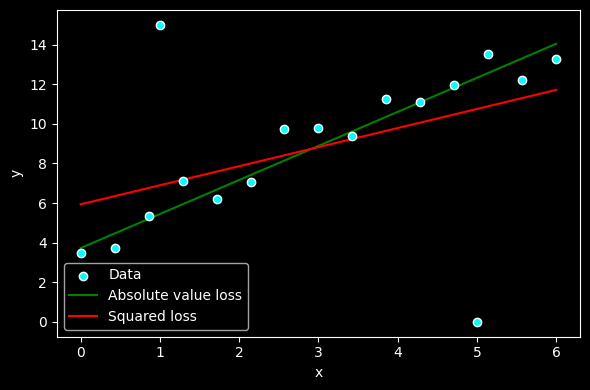

In [ ]:
fig_1, ax_1 = plt.subplots(figsize=(6, 4))

plt.scatter(A[:, 0], y, color='cyan', label='Data', edgecolors='w')
ax_1.plot([0, 6], [prediction(0, a_abs, b_abs), prediction(6, a_abs, b_abs)], 'g-', label='Absolute value loss', zorder=-5)
ax_1.plot([0, 6], [prediction(0, a, b), prediction(6, a, b)], 'r-', label='Squared loss', zorder=-5)

ax_1.set_xlabel('x')
ax_1.set_ylabel('y')
plt.tight_layout()
plt.legend()
plt.show()

#### `Comparison` of common loss functions

We compare four common loss functions

* `Squared` loss
* `Absolute value` loss
* `Deadzone` loss: introduces a region around zero (within the threshold $\delta$) where small errors $e$ are not penalized at all (deadzone), and larger errors are penalized linearly
$$J=\max\{0, |e|-\delta\}$$
* `Huber` loss: combination of squared and absolute loss. For small errors (within the threshold $\delta$), it behaves like squared loss, and for larger errors, it switches to absolute value loss. This makes Huber loss robust to outliers while still being differentiable for small errors
$$J=\left\{\begin{array}{ll} 0.5e^2 & |e| \leq \delta \\ \delta(|e|-0.5\delta) & |e|>\delta\end{array}\right.$$

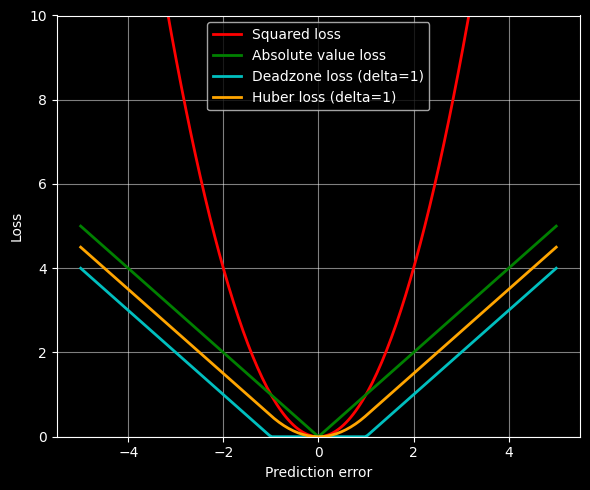

In [ ]:
errors = np.linspace(-5, 5, 200)

delta = 1.0

def squared_loss(e):
    return e ** 2

def absolute_value_loss(e):
    return np.abs(e)

def deadzone_loss(e, delta):
    return np.where(np.abs(e) < delta, 0, np.abs(e) - delta)

def huber_loss(e, delta):
    return np.where(np.abs(e) <= delta, 0.5 * e**2, delta * (np.abs(e) - 0.5 * delta))

squared = squared_loss(errors)
absolute = absolute_value_loss(errors)
deadzone = deadzone_loss(errors, delta)
huber = huber_loss(errors, delta)

plt.figure(figsize=(6, 5))
plt.plot(errors, squared, label='Squared loss', color='r', linewidth=2)
plt.plot(errors, absolute, label='Absolute value loss', color='g', linewidth=2)
plt.plot(errors, deadzone, label='Deadzone loss (delta=1)', color='c', linewidth=2)
plt.plot(errors, huber, label='Huber loss (delta=1)', color='orange', linewidth=2)
plt.xlabel('Prediction error')
plt.ylabel('Loss')
plt.ylim(0, 10)
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()